In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
# from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torchvision import datasets, transforms as T

import random, os, pathlib, time
from tqdm import tqdm
# from sklearn import datasets

In [2]:
# device = torch.device("cuda:0")
device = torch.device("cpu")

In [3]:
from tqdm import tqdm
import os, time, sys
import json

In [4]:
import dtnnlib as dtnn

In [5]:
mnist_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(
        mean=[0.5,],
        std=[0.5,],
    ),
])

# train_dataset = datasets.FashionMNIST(root="../../../_Datasets/", train=True, download=True, transform=mnist_transform)
# test_dataset = datasets.FashionMNIST(root="../../../_Datasets/", train=False, download=True, transform=mnist_transform)
train_dataset = datasets.MNIST(root="../../../_Datasets/", train=True, download=True, transform=mnist_transform)
test_dataset = datasets.MNIST(root="../../../_Datasets/", train=False, download=True, transform=mnist_transform)

In [6]:
batch_size = 50
train_loader = data.DataLoader(dataset=train_dataset, num_workers=4, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, num_workers=4, batch_size=batch_size, shuffle=False)

In [7]:
for xx, yy in train_loader:
    xx, yy = xx.to(device), yy.to(device)
    print(xx.shape, yy.shape)
    break

torch.Size([50, 1, 28, 28]) torch.Size([50])


## 1 Layer epsilon Softmax MLP

In [8]:
class DistanceTransform_Epsilon(dtnn.DistanceTransformBase):
    
    def __init__(self, input_dim, num_centers, p=2, bias=False, epsilon=0.1):
        super().__init__(input_dim, num_centers, p=2)
        
        nc = num_centers
        if epsilon is not None:
            nc += 1
        self.scaler = nn.Parameter(torch.log(torch.ones(1, 1)*1))
        self.bias = nn.Parameter(torch.ones(1, nc)*0) if bias else None
        self.epsilon = epsilon
        
    def forward(self, x):
        dists = super().forward(x)
        
        if self.epsilon is not None:
            dists = torch.cat([dists, torch.ones(len(x), 1, dtype=x.dtype)*self.epsilon], dim=1)
        
        ### normalize similar to UMAP
        dists = dists/torch.sqrt(dists.var(dim=1, keepdim=True)+1e-9)
        
        ## scale the dists
#         dists = torch.exp(-dists + self.scaler)
        dists = 1-dists*torch.exp(self.scaler)
    
        if self.bias is not None: dists = dists+self.bias
        return dists

In [9]:
class LocalMLP_epsilonsoftmax(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, epsilon=1.0):
        super().__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.new_hidden_dim = 0
        self.output_dim = output_dim
        
        self.layer0 = DistanceTransform_Epsilon(self.input_dim, self.hidden_dim, bias=True, epsilon=epsilon)
        hdim = self.hidden_dim
        if epsilon is not None:
            hdim += 1
            
#         self.scale_shift = dtnn.ScaleShift(hdim, scaler_init=3, shifter_init=0, scaler_const=True, shifter_const=True)
        self.scale_shift = dtnn.ScaleShift(hdim, scaler_init=5, shifter_init=0, scaler_const=True, shifter_const=True)
        self.softmax = nn.Softmax(dim=-1)

#         self.activ = dtnn.OneActiv(hdim, mode='relu', beta_init=np.log(1.2))
        self.activ = nn.ReLU()

        self.layer1 = nn.Linear(hdim, self.output_dim)
        self.temp_maximum = None 

    def forward(self, x):
        xo = self.layer0(x)
        xo = self.scale_shift(xo)
        xo = self.softmax(xo)
        
        self.temp_maximum = xo.data

        xo = self.activ(xo)
        xo = self.layer1(xo)
        return xo

In [10]:
h = 100
model = LocalMLP_epsilonsoftmax(784, h, 10, epsilon=None)

In [11]:
model.to(device)

LocalMLP_epsilonsoftmax(
  (layer0): DistanceTransform_Epsilon()
  (scale_shift): ScaleShift()
  (softmax): Softmax(dim=-1)
  (activ): ReLU()
  (layer1): Linear(in_features=100, out_features=10, bias=True)
)

## Train Test Function

In [12]:
best_acc = -1
def test(epoch, model):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
#         for batch_idx, (inputs, targets) in enumerate(tqdm(test_loader)):
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device).view(-1, 28*28), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
    print(f"[Test] {epoch} Loss: {test_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f} {correct}/{total}")
    
    acc = 100.*correct/total
    return acc

In [13]:
criterion = nn.CrossEntropyLoss()

## Helper Funcs

In [14]:
def get_random_training_samples(N):
    new_center = []
    new_labels = []
    count = 0
    for i, (xx, yy) in enumerate(train_loader):
        xx = xx.reshape(xx.shape[0], -1)
        if count+xx.shape[0] < N:
            new_center.append(xx)
            new_labels.append(yy)
            count += xx.shape[0]
        elif count >= N:
            break
        else:
            new_center.append(xx[:N-count])
            new_labels.append(yy[:N-count])
            count = N
            break

    new_center = torch.cat(new_center, dim=0)
    new_labels = torch.cat(new_labels, dim=0)
    
    weights = torch.zeros(len(new_labels), 10)
    for i in range(len(new_labels)):
        weights[i, new_labels[i]] = 1.
    
    return new_center.to(device), weights.to(device)

In [15]:
get_random_training_samples(2)

(tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]),
 tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]]))

In [16]:
def add_neurons_to_model(model, centers, values):
    c = torch.cat((model.layer0.centers.data, centers), dim=0)
    v = torch.cat((model.layer1.weight.data, values.t()), dim=1)
    s = torch.cat([model.layer0.bias.data, torch.ones(1, len(centers))*0], dim=1)

    model.layer0.centers.data = c
    model.layer1.weight.data = v
    model.layer0.bias.data = s
    pass

In [17]:
# add_neurons_to_model(model, *get_random_training_samples(N_search))

In [18]:
model.layer0.centers.data.shape, model.layer1.weight.data.shape

(torch.Size([100, 784]), torch.Size([10, 100]))

## Calculate Neuron Significance

In [19]:
outputs, gradients = None, None
def capture_outputs(module, inp, out):
    global outputs
    outputs = out.data.cpu()

def capture_gradients(module, gradi, grado):
    global gradients
    gradients = grado[0].data.cpu()
        
forw_hook = None
back_hook = None
def remove_hook():
    back_hook.remove()
    forw_hook.remove()

In [20]:
def none_grad():
    global model
    for p in model.parameters():
        p.grad = None

In [21]:
def remove_neurons_from_model(model, importance, num_prune):
    N = model.layer0.centers.shape[0]
    topk_idx = torch.topk(importance, k=N-num_prune, largest=True)[1]
    removing = torch.topk(importance, k=num_prune, largest=False)[1]
    print(f"Removing:\n{removing.data.sort()[0]}")
    c = model.layer0.centers.data[topk_idx]
    v = model.layer1.weight.data[:,topk_idx]
    s = model.layer0.bias.data[:,topk_idx]
    model.layer0.centers.data = c
    model.layer1.weight.data = v
    model.layer0.bias.data = s
    pass

In [22]:
# remove_neurons_from_model(model, significance, N_search)

## Noisy Selection + Finetuening

In [23]:
"""
PROBLEM 1:The neuron that does not get pruned gets trained for longer,, 
    hence can drift largely from its initialized data point (even at lower learning rate).
    - Can freeze the centers of the MLP and train only values.

PROBLEM 2:The values of each neuron might fire at different magnitude bringing different amount of
    importance for classification (even the distance of center with other centers reduces its magnitude).
    - This should be carefully handeled at initialization (or normalizing the values to unit norm).
"""
print()

In [24]:
N_search = 30
# N_search = 1

In [25]:
new_center, weights = get_random_training_samples(h)
model.layer0.centers.data = new_center.to(device)
model.layer1.weight.data = weights.t().to(device)

In [26]:
test_acc = test(0, model)

[Test] 0 Loss: 1.745 | Acc: 73.350 7335/10000


In [27]:
learning_rate = 0.01

p1, p2 = [], []
for p in model.named_parameters():
    if p[0] == "layer0.centers":
        p1.append(p[1])
    else:
        p2.append(p[1])

params = [
    {"params": p1, "lr": learning_rate*0.03}, ## default - to change little from data point
#     {"params": p1},
    {"params": p2},
]

In [28]:
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

In [29]:
## Run multiple times for convergence
EPOCHS = 10

model.train()
for s in range(EPOCHS):
    print(f"Adding, Finetuening and Pruning for STEP: {s}")
    ### Resetting optimizer every removal of neuron
    optimizer = torch.optim.Adam(params, lr=learning_rate)
    
    c, v = get_random_training_samples(N_search)
#     v *= model.layer1.weight.data.max(dim=0)[0].mean()
    v *= (model.layer1.weight.data.max() + model.layer1.weight.data.max(dim=0)[0].mean())/2
    add_neurons_to_model(model, c, v)
    
    significance = torch.zeros(model.layer0.centers.shape[0])

    forw_hook = model.softmax.register_forward_hook(capture_outputs)
    back_hook = model.softmax.register_backward_hook(capture_gradients)
    
    for xx, yy in tqdm(train_loader):
        xx = xx.to(device).view(-1, 28*28)
        ## Rescale the values to unit norm
#         model.layer1.weight.data /= model.layer1.weight.data.norm(dim=0, keepdim=True)
        
        yout = model(xx)

        none_grad()
#         yout.register_hook(lambda grad: grad/(torch.norm(grad, dim=1, keepdim=True)+1e-9))
        ####################################
#         grad = torch.randn_like(yout)
#         ### grad = grad/torch.norm(grad, dim=1, keepdim=True)
#         yout.backward(gradient=grad)
        ###################################
        loss = criterion(yout, yy)
        loss.backward()
        with torch.no_grad():
            significance += torch.sum((outputs*gradients)**2, dim=0)
#             significance += torch.sum(outputs*gradients, dim=0) ## Does not converge well
            
        optimizer.step()

    remove_hook()
    remove_neurons_from_model(model, significance, N_search)
    test_acc3 = test(0, model)
#     print(f"Accuracy: {test_acc3}")

## Finetune after finishing removal to get better performance ??

Adding, Finetuening and Pruning for STEP: 0


100%|██████████| 1200/1200 [00:09<00:00, 129.96it/s]

Removing:
tensor([  1,   7,   9,  11,  14,  15,  18,  25,  26,  32,  38,  40,  49,  52,
         55,  58,  63,  66,  72,  78,  79,  85,  89,  94,  97, 108, 110, 115,
        120, 126])


[Test] 0 Loss: 1.010 | Acc: 66.050 6605/10000
Adding, Finetuening and Pruning for STEP: 1


100%|██████████| 1200/1200 [00:08<00:00, 133.89it/s]

Removing:
tensor([ 10,  13,  43,  54,  57,  59,  60,  65,  74,  75,  76,  78,  81,  82,
         87,  88,  89,  90,  94,  99, 102, 104, 105, 107, 109, 116, 121, 123,
        124, 128])


[Test] 0 Loss: 0.773 | Acc: 73.400 7340/10000
Adding, Finetuening and Pruning for STEP: 2


100%|██████████| 1200/1200 [00:09<00:00, 120.36it/s]

Removing:
tensor([ 22,  41,  52,  54,  55,  66,  71,  76,  78,  80,  83,  84,  86,  88,
         90,  91,  92,  93,  95, 100, 101, 105, 106, 110, 112, 113, 115, 119,
        122, 126])


[Test] 0 Loss: 0.938 | Acc: 68.950 6895/10000
Adding, Finetuening and Pruning for STEP: 3


100%|██████████| 1200/1200 [00:09<00:00, 120.31it/s]

Removing:
tensor([ 29,  43,  55,  69,  72,  74,  76,  77,  79,  83,  85,  87,  88,  90,
         94,  95,  96,  97,  98,  99, 101, 103, 105, 108, 110, 112, 124, 127,
        128, 129])


[Test] 0 Loss: 0.758 | Acc: 73.480 7348/10000
Adding, Finetuening and Pruning for STEP: 4


100%|██████████| 1200/1200 [00:09<00:00, 121.47it/s]

Removing:
tensor([  3,  41,  52,  59,  61,  64,  68,  69,  75,  77,  79,  84,  86,  89,
         90,  93,  94,  96,  97,  98,  99, 101, 103, 112, 113, 116, 125, 127,
        128, 129])


[Test] 0 Loss: 0.857 | Acc: 70.850 7085/10000
Adding, Finetuening and Pruning for STEP: 5


  4%|▍         | 48/1200 [00:00<00:13, 85.61it/s] 


KeyboardInterrupt: 

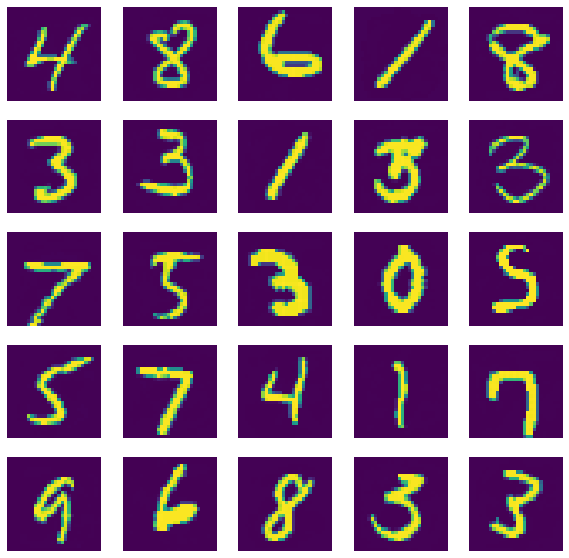

In [30]:
_, axs = plt.subplots(5, 5, figsize=(10, 10))
axs = axs.flatten()

c = model.layer0.centers.data.cpu().numpy().reshape(-1, 28,28)
# imgs = c[:len(axs)]
imgs = c[-len(axs):]

for img, ax in zip(imgs, axs):
    ax.imshow(img)
    ax.set_axis_off()

plt.show()

In [31]:
model.layer1.weight.data.shape#[:,0]

torch.Size([10, 130])

In [32]:
model.layer1.weight.data[:, 4]

tensor([ 6.3682, -9.0033, -0.7776, -6.4765, -6.9160, -1.8502, -5.0272, -5.6059,
        -3.6192, -7.4739])

In [33]:
# plt.hist(model.layer1.weight.data[0])
# plt.xlabel(f"Neuron: {0}")
# plt.show()

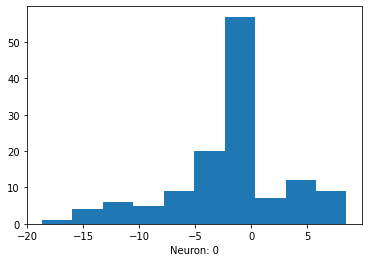

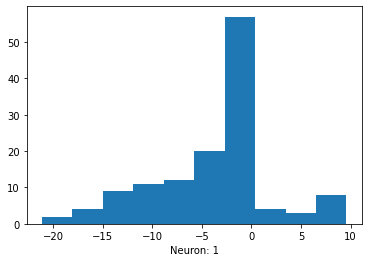

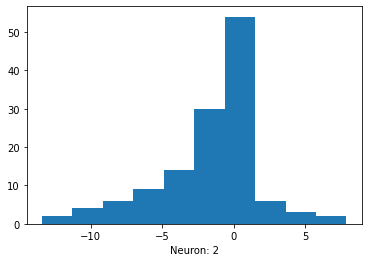

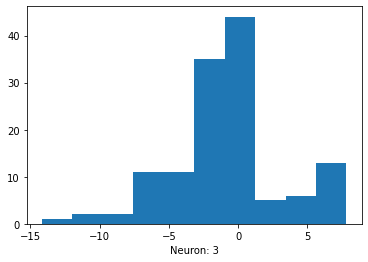

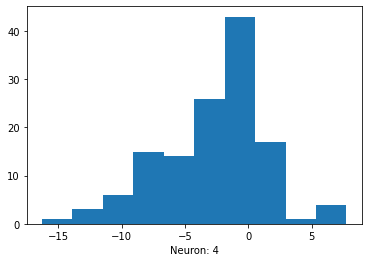

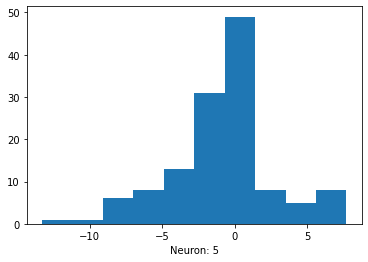

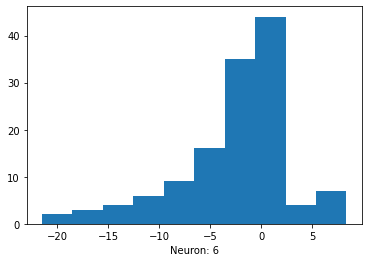

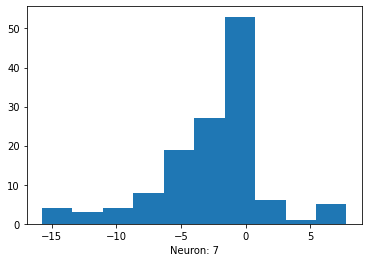

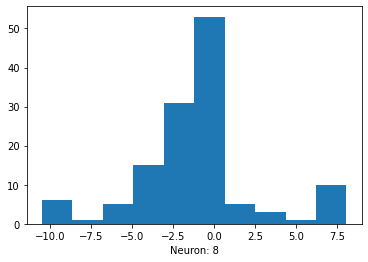

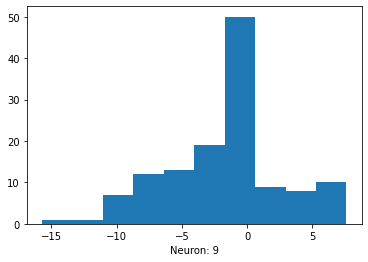

In [34]:
for i in range(model.layer1.weight.shape[0]):
    plt.hist(model.layer1.weight.data[i])
    plt.xlabel(f"Neuron: {i}")
    plt.show()

In [35]:
model.layer1.weight.data.max(dim=0)[0], model.layer1.weight.data.max(dim=0)[0].mean()

(tensor([6.2975, 6.2349, 6.1930, 3.0895, 6.3682, 6.2299, 6.6620, 5.8235, 6.4682,
         2.7082, 3.0119, 2.2432, 3.3825, 4.1174, 3.8991, 4.1786, 5.3893, 6.2551,
         3.0824, 7.0633, 3.9371, 6.4934, 5.8185, 7.1102, 4.4393, 6.5611, 6.8018,
         8.7307, 4.0885, 4.8180, 7.6850, 4.8703, 6.5577, 5.6018, 4.9089, 3.5287,
         7.2311, 5.3741, 1.8225, 6.7459, 7.6976, 2.6900, 6.2971, 5.3918, 8.0785,
         6.8736, 6.5909, 7.8787, 5.6118, 2.4301, 7.2558, 8.5176, 3.2948, 3.8433,
         7.8480, 5.2976, 6.8250, 2.9414, 7.0436, 6.4531, 3.8192, 5.2929, 3.9800,
         7.5997, 3.5267, 4.6499, 5.3418, 6.1427, 5.3613, 6.9739, 4.1968, 5.4596,
         4.9451, 5.8817, 7.5112, 4.1727, 5.7507, 5.0271, 6.9024, 2.3698, 2.2880,
         7.5913, 3.0818, 4.0485, 5.3622, 5.1525, 5.0654, 6.9562, 8.3818, 3.5706,
         7.8255, 4.5125, 6.2494, 5.1733, 5.2543, 7.9480, 5.6690, 9.5736, 2.8921,
         3.3882, 7.6990, 7.7250, 7.7771, 7.6109, 7.5122, 7.7069, 7.6830, 7.4891,
         7.3977, 7.5204, 7.6

In [36]:
model.layer1.weight.data.max(), model.layer1.weight.data.max(dim=0)[0].mean()

(tensor(9.5736), tensor(5.9573))

In [37]:
# (model.layer1.weight.data.max(dim=0)[0]**2).mean().sqrt()

In [38]:
model.layer1.weight.data.norm(dim=0, keepdim=True)

tensor([[ 6.6329,  6.3696,  6.7379, 20.5498, 18.4683,  7.2475,  8.8558,  9.0358,
         18.9708,  5.2049,  6.6082,  4.7885,  7.1015,  6.6209, 12.4794, 11.2169,
          6.9967,  7.8406, 10.1771,  8.3481,  6.1930,  9.4116, 11.1577,  7.4029,
         17.3998,  8.9685, 11.1603, 16.4597, 27.9366, 18.7463,  8.7002, 21.6692,
         12.3897, 22.2604, 26.5907, 13.4622,  9.2645, 20.3520, 25.0414, 11.9088,
         25.9923, 21.0425, 12.2023, 16.5296,  8.6757, 19.4587, 10.5774,  8.3197,
         23.5831, 21.6315,  9.2101, 11.9012, 26.7047, 20.2176,  8.9513, 31.4164,
         16.8016, 19.1174, 16.0166, 13.3681, 23.6417, 20.3846, 15.1838, 14.9126,
         27.3498, 18.4608, 20.0319, 14.1924, 19.4219, 14.1602, 30.0142, 22.7760,
         19.8587, 19.7741,  9.5570, 15.4529, 19.5861, 25.3917, 12.1571, 18.4770,
         14.0684,  9.6367, 22.3565, 20.8657, 30.2374, 23.6992, 18.5600, 20.1220,
         10.6002, 27.3962,  8.6884, 28.9374, 13.8387, 19.9316, 13.9847, 14.0183,
         16.4472, 15.3468, 2

In [39]:
model.layer0.bias.data

tensor([[-0.8350, -1.1444, -0.6148, -0.1093, -0.3805, -0.6560,  0.3013, -0.9951,
         -1.1379, -3.1103, -2.7083, -3.7361, -2.1153, -2.1109, -1.5894, -1.5972,
         -1.5833, -0.5759, -1.2988, -1.1759, -1.9208, -0.8720, -0.1803, -0.5065,
         -0.8828, -1.0107,  0.0825, -0.7095, -0.2909, -0.0661,  0.1223,  0.1328,
         -0.2348,  0.3833,  0.4458, -0.3619,  0.0896, -0.1639,  0.2299,  0.2043,
         -0.3182,  0.7017,  0.2171,  0.2393, -0.1798, -0.1729,  0.2591, -0.1113,
          1.0598,  0.3394, -0.1425,  0.1686,  0.5515,  1.1145,  0.1335,  0.0768,
          0.2288,  0.7611,  0.1354,  0.6394, -0.0884, -0.2051,  0.5351,  0.5163,
          0.5451,  0.6283,  0.3534, -0.2577,  0.1863,  0.8418,  0.0380,  0.2435,
          0.3616,  0.1549, -0.1803,  0.6744, -0.3258,  0.4801,  0.0373,  0.3569,
          0.6760, -0.0371,  0.4790,  0.1203,  0.3973, -0.0519,  0.5619,  0.2216,
          0.1549,  0.3540, -0.5594,  0.8339,  0.2946, -0.1703,  0.7280,  0.1865,
          0.9342, -0.4034,  

## Observation

In [40]:
"""
1) After epochs increase, the initial neurons solidify (and produce high importance) 
    -> 92.5% test accuracy on 10 epochs (new_neurons skewed removal)
    -> credit to large output values
    -> Try value normalization (91.88% test accuracy -> maybe it trains slower ; overall removal)
    -> Try value initialization to mean (92.88% test accuracy -> overall removal)
    -> Try value initialization to (mean+max)/2 (93.15% test accuracy -> overall removal)
    
2) Resetting optimizer hamper the accuracy reached; Noisy method helps accuracy.
3) Increasing lr of centers increases accuracy (95.02%) (also deviates more from data)
4) 

"""
print()

# With Epsilon and adverserial rejection

In [41]:
h = 100
model = LocalMLP_epsilonsoftmax(784, h, 10, epsilon=10.0)

In [42]:
N_search = 30
# N_search = 1

In [43]:
model.to(device)

LocalMLP_epsilonsoftmax(
  (layer0): DistanceTransform_Epsilon()
  (scale_shift): ScaleShift()
  (softmax): Softmax(dim=-1)
  (activ): ReLU()
  (layer1): Linear(in_features=101, out_features=10, bias=True)
)

In [44]:
## Initialization
new_center, weights = get_random_training_samples(h)
if model.layer0.epsilon is not None:
    e = torch.zeros(1, weights.shape[1])
    weights = torch.cat([weights, e], dim=0)

model.layer0.centers.data = new_center.to(device)
model.layer1.weight.data = weights.t().to(device)
# print(weights.shape)

In [45]:
test_acc = test(0, model)

[Test] 0 Loss: 2.199 | Acc: 26.100 2610/10000


In [46]:
def add_neurons_to_model(model, centers, values):
    c = torch.cat((model.layer0.centers.data, centers), dim=0)
    v = torch.cat((model.layer1.weight.data[:,:-1], values.t(), model.layer1.weight.data[:,-1:]), dim=1)
    s = torch.cat([model.layer0.bias.data[:,:-1], torch.ones(1, len(centers))*0, model.layer0.bias.data[:,-1:]], dim=1)

    model.layer0.centers.data = c
    model.layer1.weight.data = v
    model.layer0.bias.data = s
    pass

In [47]:
add_neurons_to_model(model, *get_random_training_samples(N_search))

In [48]:
model.layer0.centers.data.shape, model.layer1.weight.data.shape

(torch.Size([130, 784]), torch.Size([10, 131]))

In [49]:
def remove_neurons_from_model(model, importance, num_prune):
    N = model.layer0.centers.shape[0]
    importance = importance[:N]
    topk_idx = torch.topk(importance, k=N-num_prune, largest=True)[1]
    removing = torch.topk(importance, k=num_prune, largest=False)[1]
    print(f"Removing:\n{removing.data.sort()[0]}")
    
    c = model.layer0.centers.data[topk_idx]
    ## modifying for value tensor and bias (for epsilon value)
    topk_idx = torch.cat([topk_idx, torch.tensor([N], dtype=topk_idx.dtype)])
    s = model.layer0.bias.data[:,topk_idx]
    v = model.layer1.weight.data[:,topk_idx]
    model.layer0.centers.data = c
    model.layer1.weight.data = v
    model.layer0.bias.data = s
    pass

In [50]:
significance = torch.zeros(model.layer0.centers.shape[0]+1)

forw_hook = model.softmax.register_forward_hook(capture_outputs)
back_hook = model.softmax.register_backward_hook(capture_gradients)

for xx, yy in tqdm(train_loader):
    xx = xx.to(device).view(-1, 28*28)
    ## Rescale the values to unit norm
#     model.layer1.weight.data /= model.layer1.weight.data.norm(dim=0, keepdim=True)

    yout = model(xx)

    none_grad()
#     yout.register_hook(lambda grad: grad/(torch.norm(grad, dim=1, keepdim=True)+1e-9))
    ####################################
#     grad = torch.randn_like(yout)
#     ### grad = grad/torch.norm(grad, dim=1, keepdim=True)
#     yout.backward(gradient=grad)
    ###################################
    loss = criterion(yout, yy)
    loss.backward()
    with torch.no_grad():
        significance += torch.sum((outputs*gradients)**2, dim=0)
        
remove_hook()
none_grad()

significance.shape

100%|██████████| 1200/1200 [00:08<00:00, 139.24it/s]


torch.Size([131])

In [51]:
outputs, gradients = None, None

In [52]:
remove_neurons_from_model(model, significance, N_search)

Removing:
tensor([  9,  14,  17,  18,  25,  29,  32,  33,  35,  39,  43,  46,  48,  53,
         57,  61,  65,  67,  74,  81,  85,  89,  91,  92,  98, 106, 107, 112,
        116, 122])


In [53]:
model.layer0.centers.data.shape, model.layer1.weight.data.shape

(torch.Size([100, 784]), torch.Size([10, 101]))

In [54]:
# model.layer1.weight.data

In [55]:
test_acc = test(0, model)

[Test] 0 Loss: 2.184 | Acc: 27.900 2790/10000


In [56]:
learning_rate = 0.01

p1, p2 = [], []
for p in model.named_parameters():
    if p[0] == "layer0.centers":
        p1.append(p[1])
    else:
        p2.append(p[1])

params = [
    {"params": p1, "lr": learning_rate*0.03}, ## default - to change little from data point
#     {"params": p1},
    {"params": p2},
]

In [57]:
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

In [58]:
## Run multiple times for convergence
EPOCHS = 10 # 10

for s in range(EPOCHS):
    model.train()
    print(f"Adding, Finetuening and Pruning for STEP: {s}")
    ### Resetting optimizer every removal of neuron
    optimizer = torch.optim.Adam(params, lr=learning_rate)
    
    c, v = get_random_training_samples(N_search)
#     v *= model.layer1.weight.data.max(dim=0)[0].mean()
    v *= (model.layer1.weight.data.max() + model.layer1.weight.data.max(dim=0)[0].mean())/2
    add_neurons_to_model(model, c, v)
    
    significance = torch.zeros(model.layer0.centers.shape[0]+1)

    forw_hook = model.softmax.register_forward_hook(capture_outputs)
    back_hook = model.softmax.register_backward_hook(capture_gradients)
    
    for xx, yy in tqdm(train_loader):
        xx = xx.to(device).view(-1, 28*28)
        ## Rescale the values to unit norm
#         model.layer1.weight.data /= model.layer1.weight.data.norm(dim=0, keepdim=True)
        
        yout = model(xx)

        none_grad()
#         yout.register_hook(lambda grad: grad/(torch.norm(grad, dim=1, keepdim=True)+1e-9))
        ####################################
#         grad = torch.randn_like(yout)
#         ### grad = grad/torch.norm(grad, dim=1, keepdim=True)
#         yout.backward(gradient=grad)
        ###################################
        loss = criterion(yout, yy)
        loss.backward()
        with torch.no_grad():
            significance += torch.sum((outputs*gradients)**2, dim=0)
#             significance += torch.sum(outputs*gradients, dim=0) ## This does not converge well...

            
        optimizer.step()

    remove_hook()
    remove_neurons_from_model(model, significance, N_search)
    test_acc3 = test(0, model)
#     print(f"Accuracy: {test_acc3}")

## Finetune after finishing removal to get better performance ??

Adding, Finetuening and Pruning for STEP: 0


100%|██████████| 1200/1200 [00:09<00:00, 127.98it/s]

Removing:
tensor([  0,   1,  10,  14,  15,  19,  25,  33,  34,  36,  40,  52,  53,  57,
         58,  59,  66,  79,  83,  84,  88,  90,  97, 100, 106, 107, 114, 117,
        122, 125])


[Test] 0 Loss: 0.969 | Acc: 67.000 6700/10000
Adding, Finetuening and Pruning for STEP: 1


100%|██████████| 1200/1200 [00:09<00:00, 128.61it/s]

Removing:
tensor([ 11,  17,  28,  34,  41,  43,  44,  46,  47,  52,  53,  59,  61,  63,
         64,  69,  70,  72,  77,  82,  89,  92,  93,  95,  97, 103, 108, 115,
        116, 128])


[Test] 0 Loss: 0.731 | Acc: 75.280 7528/10000
Adding, Finetuening and Pruning for STEP: 2


100%|██████████| 1200/1200 [00:10<00:00, 117.56it/s]

Removing:
tensor([ 51,  53,  56,  63,  64,  65,  67,  68,  70,  73,  78,  80,  82,  83,
         84,  87,  88,  89,  90,  92,  94,  96,  97,  99, 109, 110, 112, 114,
        116, 118])


[Test] 0 Loss: 0.651 | Acc: 78.130 7813/10000
Adding, Finetuening and Pruning for STEP: 3


100%|██████████| 1200/1200 [00:09<00:00, 121.66it/s]

Removing:
tensor([ 37,  39,  53,  56,  61,  68,  70,  77,  78,  82,  83,  84,  85,  88,
         91,  94,  95,  96,  97,  98, 103, 104, 107, 111, 114, 117, 121, 123,
        125, 126])


[Test] 0 Loss: 0.731 | Acc: 74.580 7458/10000
Adding, Finetuening and Pruning for STEP: 4


100%|██████████| 1200/1200 [00:10<00:00, 115.66it/s]

Removing:
tensor([ 24,  33,  36,  47,  54,  61,  62,  63,  64,  66,  69,  77,  78,  81,
         82,  83,  89,  93,  94,  95,  96,  97,  98, 100, 112, 116, 122, 124,
        126, 128])


[Test] 0 Loss: 0.845 | Acc: 71.580 7158/10000
Adding, Finetuening and Pruning for STEP: 5


100%|██████████| 1200/1200 [00:10<00:00, 109.90it/s]

Removing:
tensor([  0,  35,  40,  45,  50,  52,  55,  58,  62,  63,  66,  67,  72,  76,
         82,  84,  85,  87,  88,  90,  91,  92,  93,  95,  96, 103, 106, 112,
        115, 123])


[Test] 0 Loss: 0.893 | Acc: 68.530 6853/10000
Adding, Finetuening and Pruning for STEP: 6


 69%|██████▉   | 832/1200 [00:07<00:03, 110.52it/s]
Traceback (most recent call last):
  File "/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/multiprocessing/connection.py"

KeyboardInterrupt: 

In [ ]:
gradients.shape

In [ ]:
_, axs = plt.subplots(5, 5, figsize=(10, 10))
axs = axs.flatten()

c = model.layer0.centers.data.cpu().numpy().reshape(-1, 28,28)
# imgs = c[:len(axs)]
imgs = c[-len(axs):]

for img, ax in zip(imgs, axs):
    ax.imshow(img)
    ax.set_axis_off()

plt.show()

In [ ]:
for i in range(model.layer1.weight.shape[0]):
    plt.hist(model.layer1.weight.data[i])
    plt.xlabel(f"Neuron: {i}")
    plt.show()

## Test for Adverserial Examples for e-Softmax

In [ ]:
## Copied from: 02.5_MaT_epsilonSoftmax_sample_rejection_and_adverserial_comparision_MNIST

In [ ]:
import foolbox as fb
import foolbox.attacks as fa

In [ ]:
model_ = LocalMLP_epsilonsoftmax(784, h, 10, epsilon=0.5)

In [ ]:
model_.layer0.centers.data = model.layer0.centers.data
model_.layer0.scaler.data = model.layer0.scaler.data
model_.layer0.bias.data = model.layer0.bias.data
model_.layer1.weight.data = model.layer1.weight.data
model_.layer1.bias.data = model.layer1.bias.data

In [ ]:
outputs, gradients = None, None
none_grad()

In [ ]:
for n, p in model.named_parameters():
    print(n, p.grad)

In [ ]:
fmodel = fb.PyTorchModel(model_.eval(), bounds=(-1, 1), device=device)

# attack = fa.LinfPGD()
attack = fa.FGSM()
# epsilons = [0.0, 0.001, 0.01, 0.03, 0.1, 0.3, 0.5, 1.0]

In [ ]:
count = 0
failed = 0
rejected = 0
x_rejected = 0
for i, (xx, yy) in enumerate(tqdm(test_loader)):
    xx = xx.reshape(-1, 28*28)
    
    with torch.no_grad():
        yout = model_(xx)
    reject = model_.temp_maximum.max(dim=1)[1] == model_.hidden_dim
    x_rejected += int(reject.type(torch.float32).sum())
    
    _, advs, success = attack(fmodel, xx, yy, epsilons=0.5)
    with torch.no_grad():
        yout = model_(advs)
    reject = model_.temp_maximum.max(dim=1)[1] == model_.hidden_dim
    rejected += int(reject.type(torch.float32).sum())
    
    fail = torch.bitwise_and(success, ~reject).type(torch.float32).sum()
#     fail = success.type(torch.float32).sum()
    failed += int(fail)    
    count += len(xx)

In [ ]:
count, failed, rejected, x_rejected

In [ ]:
(failed+x_rejected)/count

In [ ]:
# model_.layer0.epsilon = 5.0